In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

### Image renaming

In [15]:
import os
import glob
tif_files = sorted(os.listdir('/data1/fog/stereo-img-coastal-dem-generation/data/dem/'))
save_dir = '/data1/fog/stereo-img-coastal-dem-generation/data/dem/'
# Loop through each file
for file_path in tif_files:

    file_name = os.path.basename(file_path)
    base_name, extension = file_name.split('.', 1)

    base_name_r = base_name[:-2]
    y = base_name[-2:] 
    year = '20' + y
    new_base_name = base_name_r + year
    name_parts = new_base_name.split('_')
    new_file_name = f"{name_parts[0]}{name_parts[1]}{name_parts[2]}{name_parts[3]}.{extension}"

    new_file_path = os.path.join(os.path.dirname(save_dir), new_file_name)
    os.rename(os.path.join('/data1/fog/stereo-img-coastal-dem-generation/data/dem/', file_name), new_file_path)

In [16]:
import os

# Define the directory containing the files and the directory to save the renamed files
tif_files = sorted(os.listdir('/data1/fog/stereo-img-coastal-dem-generation/data/right/'))
save_dir = '/data1/fog/stereo-img-coastal-dem-generation/data/right/'

# Ensure the save directory exists
os.makedirs(save_dir, exist_ok=True)

# Loop through each file
for file_name in tif_files:
    # Split the file name into base name and extension
    base_name, extension = file_name.split('.', 1)
    
    # Split the base name into parts based on the first underscore
    prefix, rest = base_name.split('_', 1)
    
    # Extract the date and time part
    date_part = rest[:8]  # 01032023
    time_part = rest[9:14]  # 17-00
    
    # Reformat the date from ddmmyyyy to mmddyyyy
    reformatted_date = f"{date_part[2:4]}{date_part[:2]}{date_part[4:]}"
    
    # Remove the last two characters from the time part
    truncated_time = time_part[:-3]  # 17
    
    # Construct the new file name
    new_file_name = f"R{reformatted_date}{truncated_time}.{extension}"
    
    # Define the full path for the new file name in the save directory
    new_file_path = os.path.join(save_dir, new_file_name)
    print(new_file_path)
    
    # Rename and move the file to the save directory
    os.rename(os.path.join('/data1/fog/stereo-img-coastal-dem-generation/data/right/', file_name), new_file_path)


ValueError: not enough values to unpack (expected 2, got 1)

### Dataloader

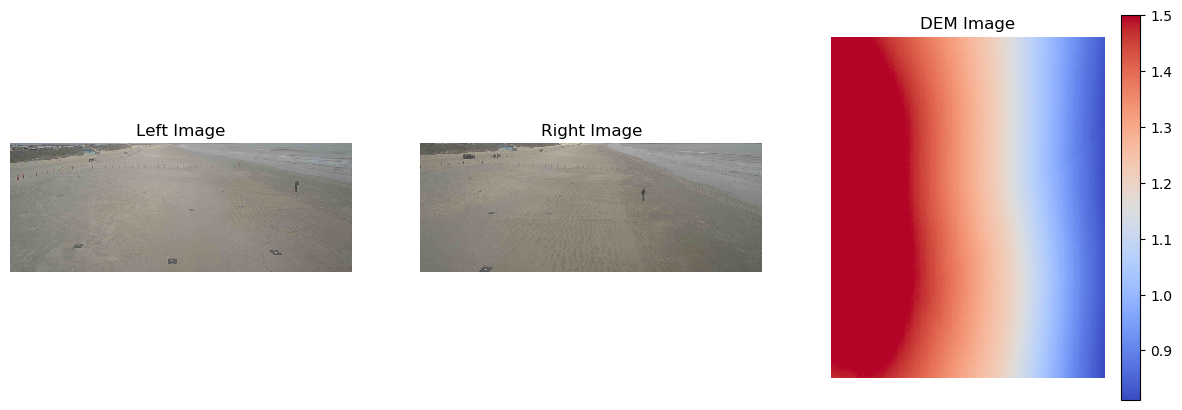

In [15]:
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image

def plot_images_by_index(index, left_dir, right_dir, dem_dir):
    # Get the list of all .tiff files in the left and right directories
    left_files = sorted(glob.glob(os.path.join(left_dir, '*.tiff')))
    right_files = sorted(glob.glob(os.path.join(right_dir, '*.tiff')))
    
    # Get the list of all .tif files in the dem directory
    dem_files = sorted(glob.glob(os.path.join(dem_dir, '*.tif')))
    
    # Extract the date and time from the left image file name
    left_file = os.path.basename(left_files[index])
    left_date_time = left_file[1:-5]  # Extract Lmmddyyyytt

    # Find the corresponding right image
    right_file = f"R{left_date_time}.tiff"

    dem_file = f"DEM{left_date_time[:-2]}.tif"  # Reformat to mmdd20yy
    
    # Check if corresponding right image and DEM file exist
    if right_file in map(os.path.basename, right_files) and dem_file in map(os.path.basename, dem_files):
        # Load images
        left_img = Image.open(os.path.join(left_dir, left_file))
        right_img = Image.open(os.path.join(right_dir, right_file))
        dem_img = Image.open(os.path.join(dem_dir, dem_file))
        dem_array = np.array(dem_img)
        # Plot images
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(left_img)
        axes[0].set_title('Left Image')
        axes[0].axis('off')
        
        axes[1].imshow(right_img)
        axes[1].set_title('Right Image')
        axes[1].axis('off')
        
        dem_plot = axes[2].imshow(dem_array, cmap='coolwarm')
        axes[2].set_title('DEM Image')
        axes[2].axis('off')
        fig.colorbar(dem_plot, ax=axes[2], orientation='vertical')
        
        plt.show()
    else:
        print(f"No matching images found for index {index}")

left_path  = '/data1/fog/stereo-img-coastal-dem-generation/data/left/'
right_path = '/data1/fog/stereo-img-coastal-dem-generation/data/right/'
dem = '/data1/fog/stereo-img-coastal-dem-generation/data/dem/'
plot_images_by_index(0, left_path, right_path, dem)

In [2]:
import os
import pandas as pd
import random
from collections import defaultdict
import glob

def split_data_into_sets(left_dir, right_dir, dem_dir):
    # Get the list of all .tiff files in the left and right directories
    left_files = sorted(glob.glob(os.path.join(left_dir, '*.tiff')))
    right_files = sorted(glob.glob(os.path.join(right_dir, '*.tiff')))
    dem_files = sorted(glob.glob(os.path.join(dem_dir, '*.tif')))
    
    # Dictionary to store lists of files by date
    data_by_date = defaultdict(list)
    
    # Extract date from DEM filenames and group files by date
    for left_file in left_files:
        left_name = os.path.basename(left_file)
        date = left_name[1:-7]  
        data_by_date[date].append(left_name)
    
    train_data = []
    valid_data = []
    test_data = []
    
    # Distribute files into train, validation, and test sets
    for date, left_files in data_by_date.items():

        if len(left_files) < 3:
            train_data.append(left_files.pop())

        elif len(left_files) == 3:
            random.shuffle(left_files)
            valid_data.append(left_files[0])
            test_data.append(left_files[1])
            train_data.append(left_files[2])
        elif len(left_files) > 3:
            random.shuffle(left_files)
            valid_data.append(left_files.pop())
            test_data.append(left_files.pop())
            train_data.extend(left_files)
        else:
            raise ValueError(f"Unexpected number of DEM files for date {date}: {len(dem_files)}")
    

    # Create the dataframes
    def create_dataframe(left_files):
        rows = []
        for left_file in left_files:
            date = os.path.basename(left_file)[1:-7]
            time_part = os.path.basename(left_file)[9:11]

            dem_file = os.path.join(dem_dir, f"DEM{date}.tif")
            right_file = os.path.join(right_dir, f"R{date}{time_part}.tiff")
            left_file = os.path.join(left_dir, f"L{date}{time_part}.tiff")
            
            if os.path.exists(left_file) and os.path.exists(right_file):
                rows.append({
                    'date': date,
                    'left_path': left_file,
                    'right_path': right_file,
                    'dem_path': dem_file
                })
        
        return pd.DataFrame(rows)

    # print(len(train_data), len(valid_data), len(test_data))
    train_df = create_dataframe(train_data)
    valid_df = create_dataframe(valid_data)
    test_df = create_dataframe(test_data)
    
    return train_df, valid_df, test_df

In [5]:
left_path  = '/home/hkaman/Documents/stereo-img-coastal-dem-generation/data/left/'
right_path = '/home/hkaman/Documents/stereo-img-coastal-dem-generation/data/right/'
dem = '/home/hkaman/Documents/stereo-img-coastal-dem-generation/data/dem'

train_df, valid_df, test_df = split_data_into_sets(left_path, right_path, dem)
print(train_df.shape, valid_df.shape, test_df.shape)

(34, 4) (11, 4) (11, 4)


In [7]:
train_df.to_csv('/home/hkaman/Documents/stereo-img-coastal-dem-generation/data/train_df.csv')
valid_df.to_csv('/home/hkaman/Documents/stereo-img-coastal-dem-generation/data/valid_df.csv')
test_df.to_csv('/home/hkaman/Documents/stereo-img-coastal-dem-generation/data/test_df.csv')

In [25]:
import numpy as np
import cv2
raw_image = np.array(Image.open('/data1/fog/stereo-img-coastal-dem-generation/data/right/R1213202317.tiff'))
image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB) / 255.0

In [ ]:
from torchvision.transforms import Compose
from DepthAnythingV2.depth_anything_v2.util.transform import Resize, NormalizeImage, PrepareForNet


transform = Compose([
    Resize(
        width=518,
        height=518,
        resize_target=False,
        keep_aspect_ratio=True,
        ensure_multiple_of=14,
        resize_method='lower_bound',
        image_interpolation_method=cv2.INTER_CUBIC,
    ),
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    PrepareForNet(),
])